Regression(0-5)

In [ ]:
!pip install transformers==2.11.0
!pip install numpy
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import functools
import itertools
import time
import os
import datetime
import re
import altair as alt
from sklearn.utils import shuffle

     |████████████████████████████████| 674 kB 9.6 MB/s 
     |████████████████████████████████| 895 kB 17.4 MB/s 
     |████████████████████████████████| 5.6 MB 20.4 MB/s 
     |████████████████████████████████| 1.2 MB 61.5 MB/s 


## Configuration

In [ ]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 5

## Load the Data

Grades Target Distribution
1.000    0.119123
0.000    0.116733
2.000    0.095923
3.000    0.088176
4.000    0.049946
           ...   
3.670    0.000039
3.875    0.000039
1.583    0.000039
0.118    0.000039
1.286    0.000039
Name: grades, Length: 190, dtype: float64


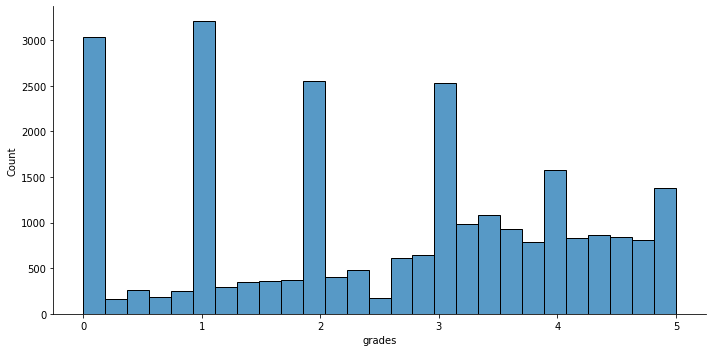

In [ ]:
graded_data= pd.read_csv("./ASAG_2021.csv")
print("Grades Target Distribution")
print(graded_data.grades.value_counts("assinding"))
#Data Distribution histogram
sns.displot( data=graded_data, x="grades", kind="hist", aspect=2)

In [ ]:
#70% train-set 15% validation & test-set
train=graded_data.iloc[:18164,:3]
val=graded_data.iloc[18164:22056,:3]
test=graded_data.iloc[22056:,:3]
# Shape of the data
print(f"Total train samples : {train.shape[0]}")
print(f"Total validation samples: {val.shape[0]}")
print(f"Total test samples: {test.shape[0]}")

Total train samples : 18164
Total validation samples: 3892
Total test samples: 3892


Grades Normalization (making all the grades in the range from 0 to 1)

In [ ]:
column = 'grades'
train[column] = (train[column] - train[column].min()) / (train[column].max() - train[column].min())
val[column] = (val[column] - val[column].min()) / (val[column].max() - val[column].min())
test[column] = (test[column] - test[column].min()) / (test[column].max() - test[column].min())

determine the labels for training, validation and testing

In [ ]:
y_train=train[column]
y_val=val[column]
y_test=test[column]

# BertSemanticDataGenerator
This class generates the batches of data to pass them to the model in the desired form.

In [ ]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=False,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="float64")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


# Pearson Correlation & Root Mean Square Error
Pearson correlation coefficlent : $r_{xy} = \frac{\sum\left((x-\overline{x})(y-\overline{y})\right)}{\sqrt{\sum(x-\overline{x})^2\sum(y-\overline{y})^2}} $

In [ ]:
def tmean(x, axis=-1):
  """Function calculates the Arithmetic mean of a tensor over some axis, default last."""
  x = tf.convert_to_tensor(x)
  sum = tf.reduce_sum(x, axis=axis)
  n = tf.cast(tf.shape(x)[axis], x.dtype)
  return sum / n

def PearsonCorrelation(x, y, axis=-2):
  """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
  x = tf.convert_to_tensor(x)
  y = math_ops.cast(y, x.dtype)
  n = tf.cast(tf.shape(x)[axis], x.dtype)
  xsum = tf.reduce_sum(x, axis=axis)
  ysum = tf.reduce_sum(y, axis=axis)
  xmean = xsum / n
  ymean = ysum / n
  xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
  yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
  cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
  corr = cov / tf.sqrt(xvar * yvar)
  return corr

def RMSE(x, y):
  """Metric returning the RMSE of two tensors over some axis"""
  return K.sqrt(K.mean(K.square(x - y)))

# Building the model

In [ ]:
# Encoded token ids from BERT tokenizer.
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")

# Attention masks indicates to the model which tokens should be attended to.
attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")

# Token type ids are binary masks identifying different sequences in the model.
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")

# Loading pretrained BERT model.
bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
# Freeze the BERT model to reuse the pretrained features without modifying them.
bert_model.trainable = False

sequence_output, pooled_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)

# Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
# Applying hybrid pooling approach to bi_lstm sequence output.
avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.3)(concat)
output = tf.keras.layers.Dense(1 ,activation="ReLU",kernel_initializer='normal')(dropout)
model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids], outputs=output)

model.compile(loss="mse" , optimizer='adam', metrics=[PearsonCorrelation,RMSE])

model.summary()


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 768), ( 1

# Passing the training, validation and testing data to the model

In [ ]:
train_data = BertSemanticDataGenerator(
    train[["model_answer", "student_answer"]].values.astype("str"),
    y_train.values,
    batch_size=batch_size,
    shuffle=True,)

val_data = BertSemanticDataGenerator(
    val[["model_answer", "student_answer"]].values.astype("str"),
    y_val.values,
    batch_size=batch_size,
    shuffle=False,)

test_data = BertSemanticDataGenerator(
    test[["model_answer", "student_answer"]].values.astype("str"),
    y_test.values,
    batch_size=batch_size,
    shuffle=False,)

# Training and Testing the Model

Training is done only for the top layers to perform "feature extraction",
which will allow the model to use the representations of the pretrained model.

In [ ]:
history = model.fit(train_data,validation_data=val_data,epochs=epochs)

Epoch 1/5
567/567 [==============================] - 227s 373ms/step - loss: 0.0417 - PearsonCorrelation: 0.7576 - RMSE: 0.2010 - val_loss: 0.0322 - val_PearsonCorrelation: 0.8356 - val_RMSE: 0.1775
Epoch 2/5
567/567 [==============================] - 212s 373ms/step - loss: 0.0318 - PearsonCorrelation: 0.8215 - RMSE: 0.1767 - val_loss: 0.0264 - val_PearsonCorrelation: 0.8512 - val_RMSE: 0.1607
Epoch 3/5
567/567 [==============================] - 212s 373ms/step - loss: 0.0295 - PearsonCorrelation: 0.8325 - RMSE: 0.1703 - val_loss: 0.0245 - val_PearsonCorrelation: 0.8575 - val_RMSE: 0.1546
Epoch 4/5
567/567 [==============================] - 212s 373ms/step - loss: 0.0278 - PearsonCorrelation: 0.8433 - RMSE: 0.1651 - val_loss: 0.0240 - val_PearsonCorrelation: 0.8641 - val_RMSE: 0.1534
Epoch 5/5
567/567 [==============================] - 212s 373ms/step - loss: 0.0264 - PearsonCorrelation: 0.8535 - RMSE: 0.1609 - val_loss: 0.0252 - val_PearsonCorrelation: 0.8667 - val_RMSE: 0.1566


In [ ]:
model.evaluate(test_data, verbose=1)

121/121 [==============================] - 35s 287ms/step - loss: 0.0258 - PearsonCorrelation: 0.8646 - RMSE: 0.1586


[0.025815829634666443, 0.8645845651626587, 0.15857449173927307]

## Fine-tuning

This step must only be performed after the feature extraction model has
been trained to convergence on the new data.

This is the last step where `bert_model` is unfreezed and retrained
with a very low learning rate. This can deliver meaningful improvement by
incrementally adapting the pretrained features to the new data.

In [ ]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss="mse",metrics=[PearsonCorrelation,RMSE])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 768), ( 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]        

# Train the entire model end-to-end.

In [ ]:
history = model.fit(train_data,validation_data=val_data,epochs=epochs,use_multiprocessing=False,workers=-1)

Epoch 1/5
567/567 [==============================] - 534s 914ms/step - loss: 0.0229 - PearsonCorrelation: 0.8733 - RMSE: 0.1499 - val_loss: 0.0208 - val_PearsonCorrelation: 0.8906 - val_RMSE: 0.1423
Epoch 2/5
567/567 [==============================] - 515s 908ms/step - loss: 0.0182 - PearsonCorrelation: 0.9002 - RMSE: 0.1335 - val_loss: 0.0184 - val_PearsonCorrelation: 0.8959 - val_RMSE: 0.1337
Epoch 3/5
567/567 [==============================] - 515s 908ms/step - loss: 0.0156 - PearsonCorrelation: 0.9145 - RMSE: 0.1236 - val_loss: 0.0187 - val_PearsonCorrelation: 0.8979 - val_RMSE: 0.1348
Epoch 4/5
567/567 [==============================] - 515s 908ms/step - loss: 0.0132 - PearsonCorrelation: 0.9295 - RMSE: 0.1135 - val_loss: 0.0186 - val_PearsonCorrelation: 0.8963 - val_RMSE: 0.1339
Epoch 5/5
567/567 [==============================] - 515s 909ms/step - loss: 0.0114 - PearsonCorrelation: 0.9389 - RMSE: 0.1055 - val_loss: 0.0189 - val_PearsonCorrelation: 0.8982 - val_RMSE: 0.1351


#Plot the "Pearson correlation & RMSE" for both training and validation with each epoch

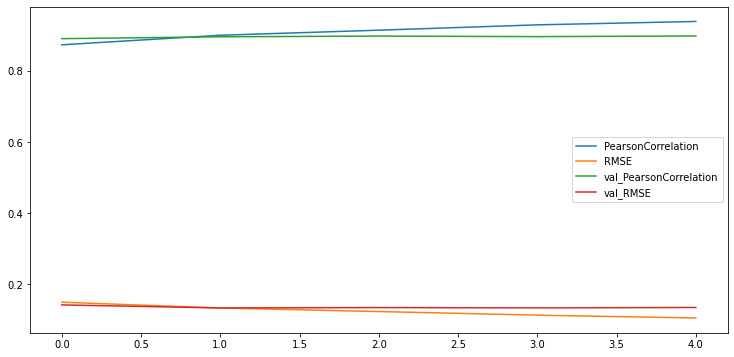

In [ ]:
hist = pd.DataFrame(history.history)
hist =hist.drop(['loss','val_loss'], axis=1)
pd.DataFrame(hist).plot(logy=False, figsize=(12.5,6))

## Evaluate model on the test set

In [ ]:
model.evaluate(test_data, verbose=1)

121/121 [==============================] - 35s 288ms/step - loss: 0.0210 - PearsonCorrelation: 0.8893 - RMSE: 0.1426


[0.020975781604647636, 0.889308750629425, 0.1426384449005127]